In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from google.colab import files

In [ ]:
file_path="/content/horizons_results.txt"

In [ ]:
with open(file_path, 'r') as f:
    lines = f.readlines()
try:
    start_index = next(i for i, line in enumerate(lines) if '$$SOE' in line) + 1
    end_index = next(i for i, line in enumerate(lines) if '$$EOE' in line)
except StopIteration:
    raise ValueError("Could not find the start ('$$SOE') or end ('$$EOE') markers in the file.")
data_block_string = ''.join(lines[start_index:end_index])
print("Successfully located and extracted the data block.")

Successfully located and extracted the data block.


In [ ]:
df = pd.read_csv(io.StringIO(data_block_string), header=None)
df.columns = [
    'JDTDB', 'Calendar_Date',
    'X', 'Y', 'Z',
    'VX', 'VY', 'VZ',
    'LT', 'RG', 'RR','UNUSED'
]

print("\n--- Data Parsed into a Table (first 5 rows) ---")
print(df.head())


--- Data Parsed into a Table (first 5 rows) ---
       JDTDB                    Calendar_Date             X             Y  \
0  2457023.5   A.D. 2015-Jan-01 00:00:00.0000  2.381863e+08 -5.583207e+07   
1  2457024.5   A.D. 2015-Jan-02 00:00:00.0000  2.382343e+08 -5.397463e+07   
2  2457025.5   A.D. 2015-Jan-03 00:00:00.0000  2.382666e+08 -5.211361e+07   
3  2457026.5   A.D. 2015-Jan-04 00:00:00.0000  2.382829e+08 -5.024912e+07   
4  2457027.5   A.D. 2015-Jan-05 00:00:00.0000  2.382834e+08 -4.838128e+07   

              Z        VX         VY        VZ          LT            RG  \
0  3.159902e+07  0.646887  21.477056  2.419301  822.818487  2.466748e+08   
1  3.180700e+07  0.464533  21.519080  2.395031  821.682528  2.463342e+08   
2  3.201288e+07  0.281388  21.559850  2.370500  820.537939  2.459911e+08   
3  3.221662e+07  0.097452  21.599354  2.345707  819.384760  2.456454e+08   
4  3.241821e+07 -0.087270  21.637578  2.320653  818.223031  2.452971e+08   

         RR  UNUSED  
0 -3.9265

In [ ]:
clean_df = df[['X', 'Y', 'Z']].copy()
clean_df.to_csv('eros_clean_data.csv', index=False)

print("\n--- Final Clean Dataset (first 5 rows) ---")
print(clean_df.head())
print(f"\nSuccessfully cleaned the data and saved it to 'eros_clean_data.csv'")


--- Final Clean Dataset (first 5 rows) ---
              X             Y             Z
0  2.381863e+08 -5.583207e+07  3.159902e+07
1  2.382343e+08 -5.397463e+07  3.180700e+07
2  2.382666e+08 -5.211361e+07  3.201288e+07
3  2.382829e+08 -5.024912e+07  3.221662e+07
4  2.382834e+08 -4.838128e+07  3.241821e+07

Successfully cleaned the data and saved it to 'eros_clean_data.csv'


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(clean_df)
print("--- Data after Normalization (first 5 rows) ---")
print(data_normalized[:5])

--- Data after Normalization (first 5 rows) ---
[[0.99958637 0.46481873 0.89767405]
 [0.99969975 0.46913144 0.90027658]
 [0.99977584 0.47345246 0.90285272]
 [0.99981449 0.47778152 0.90540221]
 [0.99981555 0.48211839 0.90792474]]


In [ ]:
def create_sequences(data, input_length, output_length):
    X = []
    y = []

    for i in range(len(data) - input_length - output_length + 1):
        input_seq = data[i : i + input_length]
        X.append(input_seq)
        output_seq = data[i + input_length : i + input_length + output_length]
        y.append(output_seq)

    return np.array(X), np.array(y)
INPUT_LENGTH = 60
OUTPUT_LENGTH = 10
X, y = create_sequences(data_normalized, INPUT_LENGTH, OUTPUT_LENGTH)

print("\n--- Final Data Shapes for Training ---")
print(f"Shape of input sequences (X): {X.shape}")
print(f"Shape of output labels (y): {y.shape}")


--- Final Data Shapes for Training ---
Shape of input sequences (X): (2489, 60, 3)
Shape of output labels (y): (2489, 10, 3)


In [ ]:
split_index = int(len(data_normalized) * 0.8)

train_data = data_normalized[:split_index]
test_data  = data_normalized[split_index:]

X_train, y_train = create_sequences(train_data, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test   = create_sequences(test_data, INPUT_LENGTH, OUTPUT_LENGTH)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, GRU, Bidirectional
import tensorflow as tf

model = Sequential([

    LSTM(46, return_sequences=True, input_shape=(INPUT_LENGTH, 3)),


    LSTM(46, return_sequences=False),

    Dense(100, activation='relu'),


    Dense(OUTPUT_LENGTH * 3),


    Reshape([OUTPUT_LENGTH, 3])
])

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam

custom_optimizer = Adam(learning_rate=0.0001)


model.compile(optimizer=custom_optimizer, loss='mean_squared_error')

model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 46)         │         9,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 46)             │        17,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │         4,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 10, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,042 (132.98 KB)

 Trainable params: 34,042 (132.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("\nStarting model training... (This will take a few minutes)")


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)
gru_training_time = time.time() - start_time
print(f"LSTM Training Complete. Time taken: {gru_training_time:.2f} seconds")
print("Training complete.")


Starting model training... (This will take a few minutes)
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3706 - val_loss: 0.1574 - learning_rate: 1.0000e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2229 - val_loss: 0.0685 - learning_rate: 1.0000e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0696 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0311 - val_loss: 0.0203 - learning_rate: 1.0000e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0132 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0027 - learning_rate: 1.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 

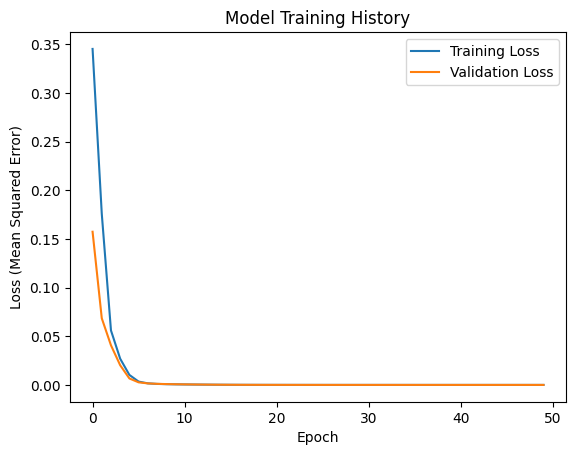

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:

test_loss = model.evaluate(X_test, y_test)
print(f"\nModel Test Loss (Mean Squared Error): {test_loss}")

sample_input_normalized = X_test[0]
sample_output_normalized = y_test[0]


input_for_model = np.reshape(sample_input_normalized, (1, INPUT_LENGTH, 3))


predicted_normalized = model.predict(input_for_model)


history_coords = scaler.inverse_transform(sample_input_normalized)

actual_coords = scaler.inverse_transform(sample_output_normalized)


predicted_coords = scaler.inverse_transform(predicted_normalized.reshape(OUTPUT_LENGTH, 3))

print("\n--- PREDICTION RESULTS (in km) ---")
print("First 3 days of PREDICTED path:\n", predicted_coords[:3])
print("\nFirst 3 days of ACTUAL path:\n", actual_coords[:3])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4237e-05

Model Test Loss (Mean Squared Error): 2.0133471480221488e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step

--- PREDICTION RESULTS (in km) ---
First 3 days of PREDICTED path:
 [[-1.8271486e+07  1.6933944e+08  1.4995204e+07]
 [-2.3068216e+07  1.7142597e+08  1.4635027e+07]
 [-2.4632738e+07  1.7170845e+08  1.4267623e+07]]

First 3 days of ACTUAL path:
 [[-2.09121334e+07  1.70896987e+08  1.51189029e+07]
 [-2.34543181e+07  1.70388658e+08  1.46623222e+07]
 [-2.59919855e+07  1.69847512e+08  1.42029174e+07]]


In [ ]:
def calculate_mape(actual, predicted):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).
    """
    abs_error = np.abs(actual - predicted)


    epsilon = 1e-6
    perc_error = (abs_error / (np.abs(actual) + epsilon)) * 100


    return np.mean(perc_error)


mape = calculate_mape(actual_coords, predicted_coords)

print(f"\nModel Mean Absolute Percentage Error (MAPE): {mape:.4f} %")


accuracy_percentage = 100.0 - mape
print(f"This means the model is, on average, {accuracy_percentage:.4f} % accurate in its predictions.")


Model Mean Absolute Percentage Error (MAPE): 3.0408 %
This means the model is, on average, 96.9592 % accurate in its predictions.


In [ ]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Reshape
from tensorflow.keras.optimizers import Adam

print("Building GRU Model...")


model_gru = Sequential([
    GRU(16, return_sequences=True, input_shape=(INPUT_LENGTH, 3)),
    GRU(16, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(OUTPUT_LENGTH * 3),
    Reshape([OUTPUT_LENGTH, 3])
])


custom_optimizer = Adam(learning_rate=0.02)
model_gru.compile(optimizer=custom_optimizer, loss='mean_squared_error')


print("Starting GRU training...")
start_time = time.time()

history_gru = model_gru.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

gru_training_time = time.time() - start_time
print(f"GRU Training Complete. Time taken: {gru_training_time:.2f} seconds")

Building GRU Model...
Starting GRU training...
Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0794 - val_loss: 2.5261e-04
Epoch 2/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8134e-04 - val_loss: 5.4957e-05
Epoch 3/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2308e-05 - val_loss: 5.7594e-05
Epoch 4/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8502e-05 - val_loss: 4.6315e-05
Epoch 5/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9080e-04 - val_loss: 8.0435e-05
Epoch 6/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0725e-05 - val_loss: 1.3120e-05
Epoch 7/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0226e-05 - val_loss: 2.2071e-05
Epoch 8/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6434e-05 - val_loss: 4.6938e-05
Epoch 9/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2329e-04 - val_loss: 0.0011
Epoch 10/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8713e-04 - val_loss: 2.0362e-05
Epoch 11/70
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2734e-05 - val_loss: 1.6739e-05

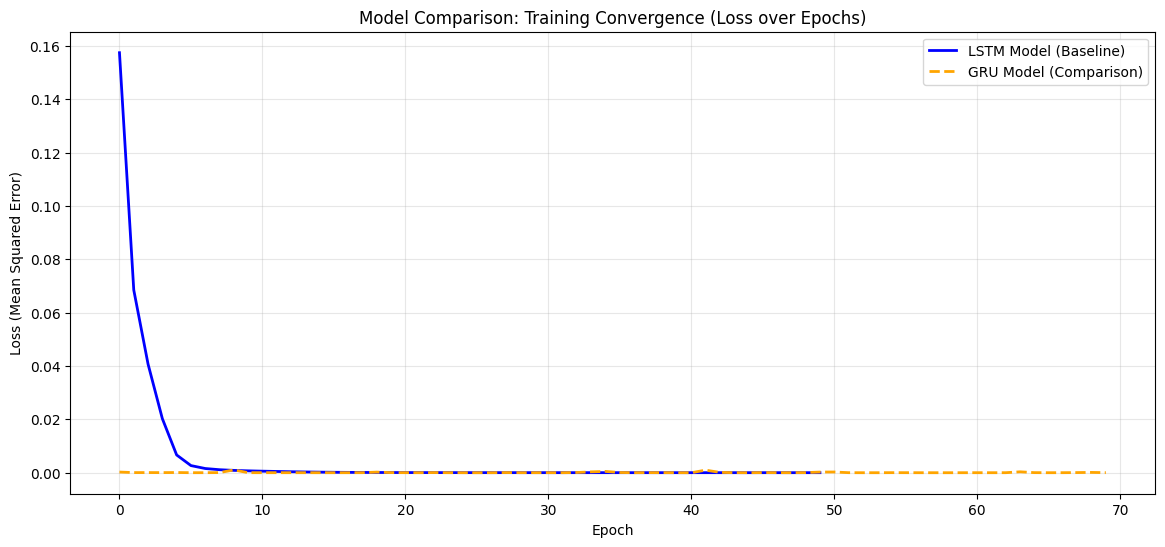

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


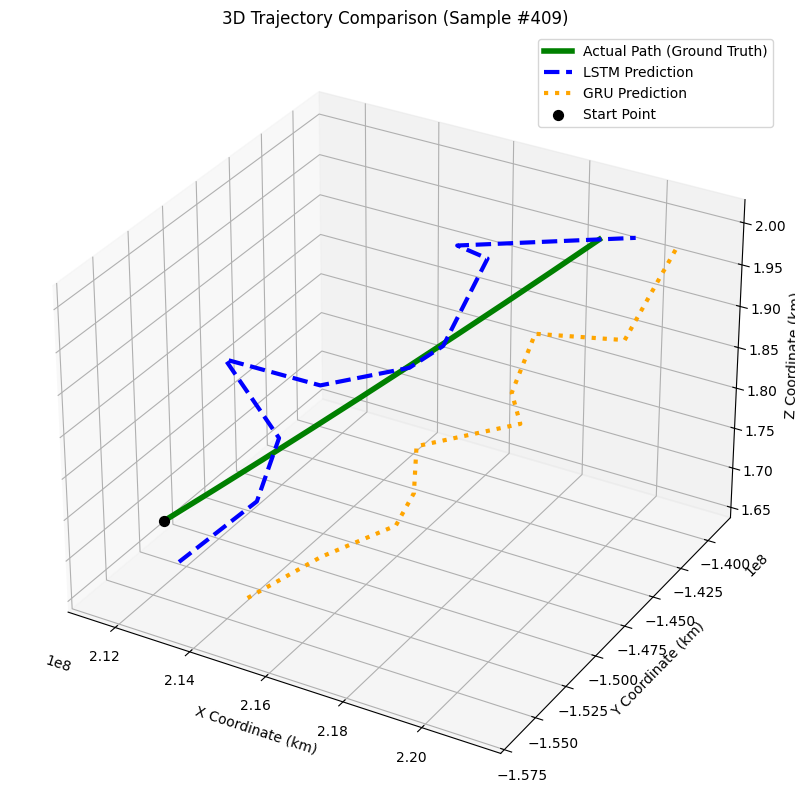

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))
plt.plot(history.history['val_loss'], label='LSTM Model (Baseline)', color='blue', linewidth=2)


plt.plot(history_gru.history['val_loss'], label='GRU Model (Comparison)', color='orange', linewidth=2, linestyle='--')

plt.title('Model Comparison: Training Convergence (Loss over Epochs)')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


sample_idx = np.random.randint(0, len(X_test))
input_seq = X_test[sample_idx]
actual_output = y_test[sample_idx]

input_reshaped = input_seq.reshape(1, INPUT_LENGTH, 3)

pred_lstm = model.predict(input_reshaped)
pred_gru = model_gru.predict(input_reshaped)


actual_km = scaler.inverse_transform(actual_output)
pred_lstm_km = scaler.inverse_transform(pred_lstm.reshape(OUTPUT_LENGTH, 3))
pred_gru_km = scaler.inverse_transform(pred_gru.reshape(OUTPUT_LENGTH, 3))

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')


ax.plot3D(actual_km[:,0], actual_km[:,1], actual_km[:,2],
          color='green', label='Actual Path (Ground Truth)', linewidth=4)

ax.plot3D(pred_lstm_km[:,0], pred_lstm_km[:,1], pred_lstm_km[:,2],
          color='blue', label='LSTM Prediction', linewidth=3, linestyle='--')


ax.plot3D(pred_gru_km[:,0], pred_gru_km[:,1], pred_gru_km[:,2],
          color='orange', label='GRU Prediction', linewidth=3, linestyle=':')


ax.scatter(actual_km[0,0], actual_km[0,1], actual_km[0,2], color='black', s=50, label='Start Point')

ax.set_title(f'3D Trajectory Comparison (Sample #{sample_idx})')
ax.set_xlabel('X Coordinate (km)')
ax.set_ylabel('Y Coordinate (km)')
ax.set_zlabel('Z Coordinate (km)')
ax.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model_performance(actual_km, predicted_km):
    """
    Calculates comprehensive metrics for 3D trajectory prediction.
    Args:
        actual_km (np.array): The ground truth path in kilometers.
        predicted_km (np.array): The model's predicted path in kilometers.
    """

    print("--- Model Performance Report ---")


    distances = np.linalg.norm(actual_km - predicted_km, axis=1)
    avg_distance_error = np.mean(distances)
    print(f"1. Average Euclidean Distance Error: {avg_distance_error:,.2f} km")
    print(f"   (The prediction is, on average, this far away from the real asteroid)")

    mse = mean_squared_error(actual_km, predicted_km)
    rmse = np.sqrt(mse)
    print(f"2. RMSE (Overall): {rmse:,.2f} km")

    mae = mean_absolute_error(actual_km, predicted_km)
    print(f"3. MAE (Overall): {mae:,.2f} km")

    r2 = r2_score(actual_km, predicted_km)
    print(f"4. R-Squared Score: {r2:.5f} (Closer to 1.0 is better)")

    return avg_distance_error


evaluate_model_performance(actual_coords, predicted_coords)

--- Model Performance Report ---
1. Average Euclidean Distance Error: 2,572,798.41 km
   (The prediction is, on average, this far away from the real asteroid)
2. RMSE (Overall): 1,641,041.32 km
3. MAE (Overall): 1,213,973.75 km
4. R-Squared Score: 0.71868 (Closer to 1.0 is better)


np.float64(2572798.4080663132)

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

pred_lstm_norm = model.predict(X_test, verbose=0)
pred_gru_norm = model_gru.predict(X_test, verbose=0)

p scaler.inverse_transform(pred_lstm_norm.reshape(-1, 3)).reshape(-1, OUTPUT_LENGTH, 3)
pred_gru_km = scaler.inverse_transform(pred_gru_norm.reshape(-1, 3)).reshape(-1, OUTPUT_LENGTH, 3)
actual_km = scaler.inverse_transform(y_test.reshape(-1, 3)).reshape(-1, OUTPUT_LENGTH, 3)


def calculate_acred_lstm_km =curacy(actual, predicted):
    """
    Calculates accuracy as 100% - Mean Absolute Percentage Error (MAPE)
    """
    epsilon = 1e-6
    abs_error = np.abs(actual - predicted)
    perc_error = (abs_error / (np.abs(actual) + epsilon)) * 100

    mape = np.mean(perc_error)

    accuracy = 100.0 - mape
    return accuracy, mape

acc_lstm, mape_lstm = calculate_accuracy(actual_km, pred_lstm_km)

acc_gru, mape_gru = calculate_accuracy(actual_km, pred_gru_km)

print("\n" + "="*50)
print(f"FINAL MODEL ACCURACY SHOWDOWN ")
print("="*50)
print(f"{'METRIC':<25} | {'LSTM (Baseline)':<10} | {'GRU (Comparison)':<10}")
print("-" * 50)
print(f"{'Accuracy (%)':<25} | {acc_lstm:.4f}%    | {acc_gru:.4f}%")
print(f"{'Error Rate (MAPE)':<25} | {mape_lstm:.4f}%     | {mape_gru:.4f}%")
print("-" * 50)

diff = abs(acc_lstm - acc_gru)
if acc_lstm > acc_gru:
    print(f"\nWINNER: LSTM Model is more accurate by {diff:.4f}%")
else:
    print(f"\nWINNER: GRU Model is more accurate by {diff:.4f}%")
print("="*50)


FINAL MODEL ACCURACY SHOWDOWN 
METRIC                    | LSTM (Baseline) | GRU (Comparison)
--------------------------------------------------
Accuracy (%)              | 94.6412%    | 93.6494%
Error Rate (MAPE)         | 5.3588%     | 6.3506%
--------------------------------------------------

WINNER: LSTM Model is more accurate by 0.9919%
